In [1]:
import os
import pandas as pd
import numpy as np
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import seaborn as sns

import string
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize
import re

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer

from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, accuracy_score, f1_score

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [3]:
# For handling warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\utgoy\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\utgoy\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\utgoy\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\utgoy\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Download the data

In [6]:
train_data = pd.read_csv('../data/train.csv', header=None)
train_data.columns=['polarity', 'title', 'text',]

val_data = pd.read_csv('../data/val.csv', header=None)
val_data.columns=['polarity', 'title', 'text',]

test_data = pd.read_csv('../data/test.csv')

In [7]:
# get all train data
X_train   = train_data['text']
y_train   = train_data['polarity']

# get val data
X_val    = val_data['text']
y_val    = val_data['polarity']

# get test data
X_test   = test_data['text']
y_test   = test_data['polarity']

print(f"Train Data Shape: {X_train.shape[0]:,}")
print(f"Validation Data Shape: {X_val.shape[0]:,}")
print(f"Test Data Shape: {X_test.shape[0]:,}")

print(" ")
print(f"Number of labels = 1 in train dataset as percentage: {((y_train == 1).sum() / (X_train.shape[0])) * 100:0.2f}%")
print(f"Number of labels = 2 in train dataset as percentage: {((y_train == 2).sum() / (X_train.shape[0])) * 100:0.2f}%")

print(" ")
print(f"Number of labels = 1 in val dataset as percentage: {((y_val == 1).sum() / (X_val.shape[0])) * 100:0.2f}%")
print(f"Number of labels = 2 in val dataset as percentage: {((y_val == 2).sum() / (X_val.shape[0])) * 100:0.2f}%")

print(" ")
print(f"Number of labels = 1 in test dataset as percentage: {((y_test == 1).sum() / (X_test.shape[0])) * 100:0.2f}%")
print(f"Number of labels = 2 in test dataset as percentage: {((y_test == 2).sum() / (X_test.shape[0])) * 100:0.2f}%")

Train Data Shape: 3,600,000
Validation Data Shape: 400,000
Test Data Shape: 33,161
 
Number of labels = 1 in train dataset as percentage: 50.00%
Number of labels = 2 in train dataset as percentage: 50.00%
 
Number of labels = 1 in val dataset as percentage: 50.00%
Number of labels = 2 in val dataset as percentage: 50.00%
 
Number of labels = 1 in test dataset as percentage: 2.45%
Number of labels = 2 in test dataset as percentage: 97.55%


In [8]:
# def clean(text):
#     text = re.sub(r'^https?:\/\/.*[\r\n]*', '', str(text), flags=re.MULTILINE)
#     texter = re.sub(r"<br />", " ", text)
#     texter = re.sub(r"&quot;", "\"",texter)
#     texter = re.sub('&#39;', "\"", texter)
#     texter = re.sub('\n', " ", texter)
#     texter = re.sub(' u '," you ", texter)
#     texter = re.sub('`',"", texter)
#     texter = re.sub(' +', ' ', texter)
#     texter = re.sub(r"(!)\1+", r"!", texter)
#     texter = re.sub(r"(\?)\1+", r"?", texter)
#     texter = re.sub('&amp;', 'and', texter)
#     texter = re.sub('\r', ' ',texter)
#     #added substitutions

#     #***********added substitutions***********
#     # remove all the special characters
#     texter = re.sub(r'\W', ' ', texter)
#     # remove all single characters
#     texter = re.sub(r'\s+[a-zA-Z]\s+', ' ', texter)
#     # Remove single characters from the start
#     texter = re.sub(r'\^[a-zA-Z]\s+', ' ', texter)
#     # Remove numbers
#     texter = re.sub(r'\d+', ' ', texter)
#     # Converting to Lowercase
#     texter = texter.lower()
#     # Remove punctuation
#     texter = re.sub(r'[^\w\s]', ' ', texter)
#     # Remove parentheses
#     texter = re.sub(r'\([^)]*\)', ' ', texter)
#     # Remove single quotes
#     texter = re.sub(r'\'', ' ', texter)
#     # Substituting multiple spaces with single space
#     texter = re.sub(r'\s+', ' ', texter, flags=re.I)

#     clean = re.compile('<.*?>')
#     texter = texter.encode('ascii', 'ignore').decode('ascii')
#     texter = re.sub(clean, '', texter)
#     if texter == "":
#         texter = ""
#     return texter

# def clean_dataset(dataset):
#     for row in range(dataset.shape[0]):
#         dataset[row,0] = clean(dataset[row,0])
#     return dataset

# def tokenize_lexicon(texts):
#     return_texts = []
#     for i in range(len(texts)):
#         return_texts.append(nltk.word_tokenize(texts[i]))
#         return_texts[i] = nltk.pos_tag(return_texts[i])
#     return return_texts

# def get_wordnet_pos(pos_tag):
#     if pos_tag.startswith('J'):
#         return wn.ADJ
#     elif pos_tag.startswith('V'):
#         return wn.VERB
#     elif pos_tag.startswith('N'):
#         return wn.NOUN
#     elif pos_tag.startswith('R'):
#         return wn.ADV
#     else:
#         return wn.NOUN

# def lemmatize_texts(texts):
#     return_texts = []
#     lemmer = nltk.stem.WordNetLemmatizer()
#     for i in range(len(texts)):
#         return_texts.append([])
#         for j in range(len(texts[i])):
#                 return_texts[i].append(lemmer.lemmatize(texts[i][j][0], pos=get_wordnet_pos(texts[i][j][1])))
#     return return_texts

# def stem_texts(texts):
#     return_texts = []
#     ps = PorterStemmer()
#     for i in range(len(texts)):
#         return_texts.append([])
#         for j in range(len(texts[i])):
#                 return_texts[i].append(ps.stem(texts[i][j][0]))
#     return return_texts

# def backtostring(texts):
#     return_texts = []
#     for i in range(len(texts)):
#         return_texts.append(" ".join(texts[i]))
#     return return_texts

# def pre_process(text):
#     # Ensure input is a string
#     text = str(text)
    
#     # 1. Convert to lowercase
#     text = text.lower()

#     # 2. Remove punctuation
#     mapping = str.maketrans('', '', string.punctuation)
#     text = text.translate(mapping)
    
#     # 3. Remove stop words
#     stop_words = set(stopwords.words('english'))
#     text = ' '.join([word for word in text.split() if word not in stop_words])
    
#     # 4. Apply the clean function
#     text = clean(text)
    
#     return text

# # get the preprocessed data
# df_text['text_cleaned'] = df_text['text'].apply(pre_process)

# # Add a new column for review length
# df_text['text_length'] = df_text['text'].fillna('').apply(lambda x: len(x.split()))

# df_text.to_csv('../data/all_reviews.csv', index=False)

In [9]:
df_text = pd.read_csv('../data/all_reviews.csv')
df_text.sample(5)

,polarity,title,text,text_cleaned,text_length
3931237,1,"Disappointing, though slightly redeeming at th...",Speed of Darkness is one of the most original ...,speed darkness one original starcraft novels d...,128
1714310,1,This Movie Begs for a negative rating,This is the type of movie that is so bad that ...,type movie bad cant rated youd think endless m...,121
272143,1,Intriguing but ultimately frustrating,This movie is about Dora Carrington's love lif...,movie dora carringtons love life effective exp...,180
2744201,1,Will not play in US DVD's,"When I purchased this DVD, it did not list tha...",purchased dvd list would work us dvd players s...,72
3717781,1,Show me the money,The author's conclusion that the Korean War an...,authors conclusion korean war subsequent secur...,118


# Length of Reviews

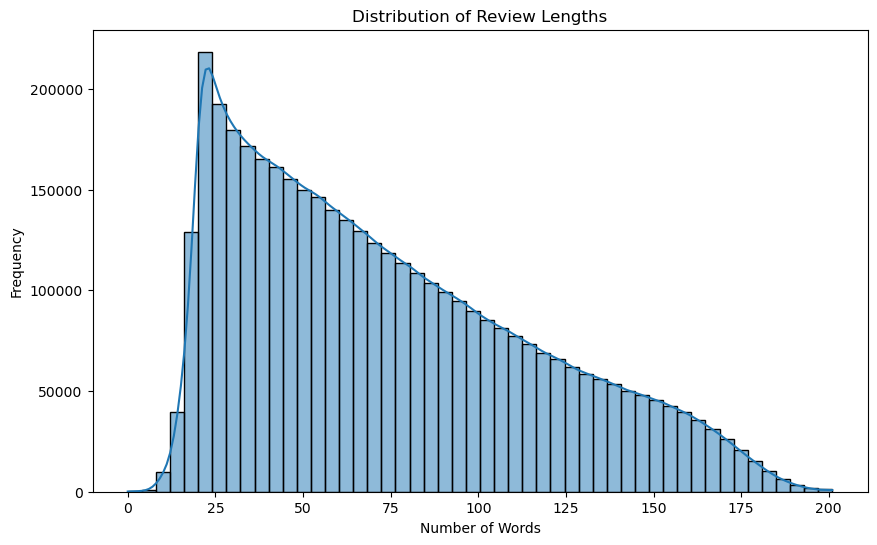

In [30]:
df_text['text_length_adj'] = np.where(df_text['text_length']>200, 201, df_text['text_length'])

# Plot distribution of review lengths
plt.figure(figsize=(10,6))
sns.histplot(df_text['text_length_adj'], bins=50, kde=True)
plt.title('Distribution of Review Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

In [38]:
df_text[df_text['polarity'] == 1]['text_length'].median()

70.0

In [39]:
df_text[df_text['polarity'] == 2]['text_length'].median()

61.0

In [54]:
# df_text[df_text['text_length_adj'] == 201].sort_values('text_length').value_counts('polarity')

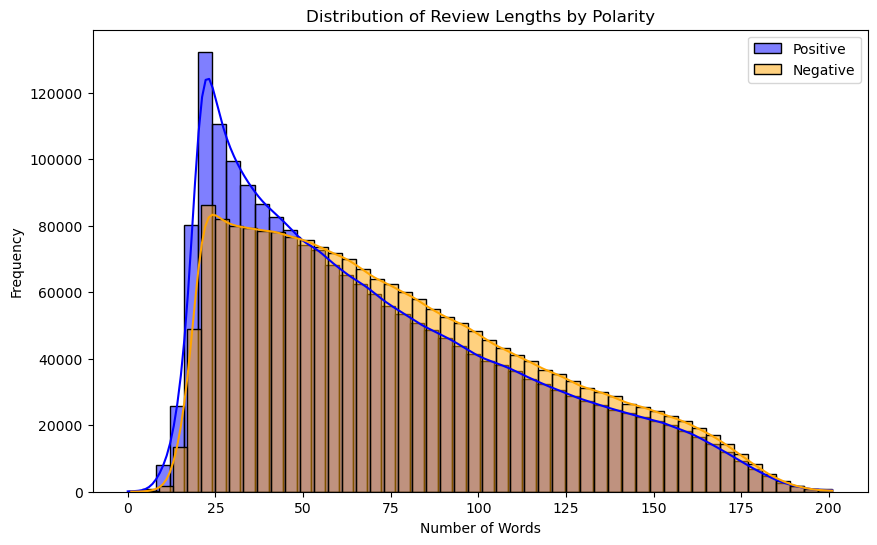

In [33]:
plt.figure(figsize=(10,6))

sns.histplot(
    df_text[df_text['polarity'] == 2]['text_length_adj'], 
    bins=50, 
    kde=True, 
    color='blue', 
    label='Positive', 
    alpha=0.5
)

sns.histplot(
    df_text[df_text['polarity'] == 1]['text_length_adj'], 
    bins=50, 
    kde=True, 
    color='orange', 
    label='Negative', 
    alpha=0.5
)

plt.title('Distribution of Review Lengths by Polarity')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# World Cloud

In [26]:
from wordcloud import WordCloud
stop = set(stopwords.words('english'))

In [27]:
def wordcloud_draw(dataset, color = 'white'):
    words = ' '.join(dataset)
    
    cleaned_word = ' '.join([word for word in words.split()
                           if (word != 'book' and word != 'text')])
    
    wordcloud = WordCloud(stopwords = stop,
                        background_color = color,
                        width = 2500, height = 2500).generate(cleaned_word)

    plt.figure(1, figsize = (10,7))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

## Positive

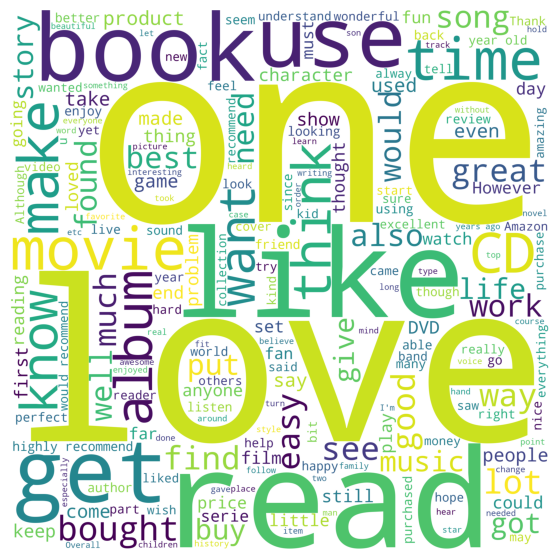

In [28]:
positive = df_text[df_text['polarity'] == 2]['text'].fillna('')
wordcloud_draw(positive, 'white')

## Negative

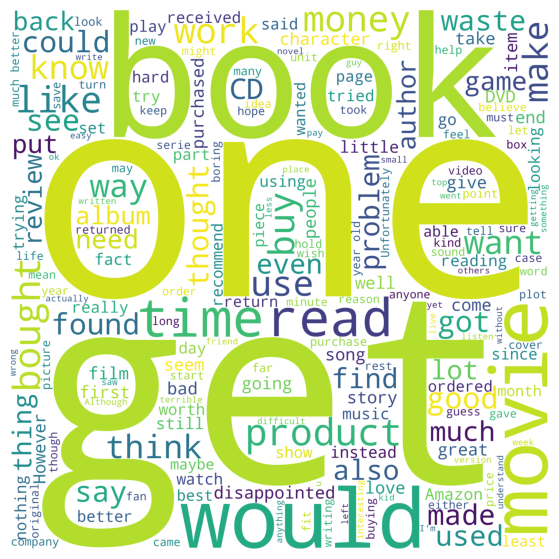

In [30]:
negative = df_text[df_text['polarity'] == 1]['text'].fillna('')
wordcloud_draw(negative, 'white')

## Positive - Clean

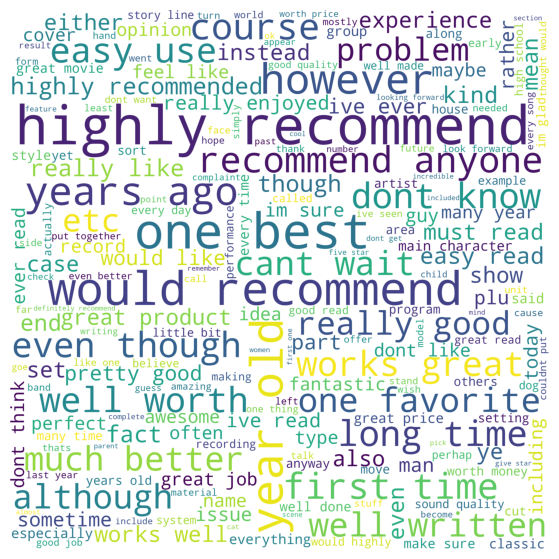

In [32]:
positive_clean = df_text[df_text['polarity'] == 2]['text_cleaned'].fillna('')
wordcloud_draw(positive_clean, 'white')

## Negative - Clean

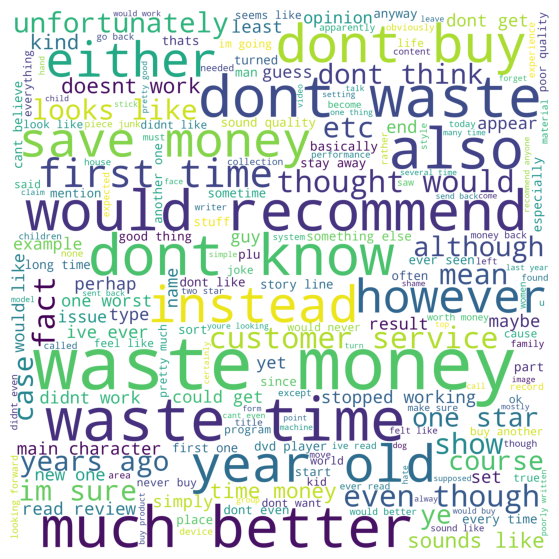

In [34]:
negative_clean = df_text[df_text['polarity'] == 1]['text_cleaned'].fillna('')
wordcloud_draw(negative_clean, 'white')

## Most Frequent 

In [36]:
# Combine all reviews into one string
all_reviews = ' '.join(df_text['text_cleaned'].fillna(''))

# Tokenize the words
tokens = word_tokenize(all_reviews.lower())

# Remove punctuation and stopwords
tokens = [word for word in tokens if word.isalpha()]
stop_words = set(stopwords.words('english'))
tokens = [word for word in tokens if word not in stop_words]

# Get word frequencies
word_freq = Counter(tokens)

# Display the most common words
common_words = word_freq.most_common(20)
print("Most common words:", common_words)

Most common words: [('book', 1952659), ('one', 1397636), ('like', 1085801), ('good', 914600), ('would', 914214), ('great', 877574), ('get', 727255), ('read', 692084), ('time', 671854), ('dont', 610406), ('really', 608518), ('movie', 579582), ('even', 538440), ('well', 537821), ('much', 532717), ('first', 527491), ('love', 458906), ('use', 433830), ('buy', 428204), ('product', 417374)]


In [51]:
# Function to get word frequencies
def get_word_freq(reviews):
    all_reviews = ' '.join(reviews)
    tokens = word_tokenize(all_reviews.lower())
    tokens = [word for word in tokens if word.isalpha()]
    tokens = [word for word in tokens if word not in stop_words]
    word_freq = Counter(tokens)
    return word_freq

# Get word frequencies
positive_word_freq = get_word_freq(positive_clean)
negative_word_freq = get_word_freq(negative_clean)

# Top words in positive reviews
positive_common_words = positive_word_freq.most_common(20)
print("Most common words in positive reviews:", positive_common_words)

# Top words in negative reviews
negative_common_words = negative_word_freq.most_common(20)
print("Most common words in negative reviews:", negative_common_words)

Most common words in positive reviews: [('book', 992355), ('one', 679184), ('great', 657249), ('like', 514501), ('good', 508776), ('read', 390565), ('would', 351966), ('love', 342882), ('well', 334682), ('really', 313738), ('get', 312741), ('time', 311954), ('best', 261310), ('movie', 260125), ('first', 253713), ('much', 241705), ('also', 237744), ('cd', 234582), ('album', 226802), ('dont', 218247)]
Most common words in negative reviews: [('book', 960304), ('one', 718452), ('like', 571300), ('would', 562248), ('get', 414514), ('good', 405824), ('dont', 392159), ('time', 359900), ('even', 340013), ('movie', 319457), ('read', 301519), ('really', 294780), ('much', 291012), ('product', 273921), ('first', 273778), ('buy', 266915), ('money', 246917), ('bought', 241093), ('better', 239068), ('could', 235947)]
